In [17]:
import sys
sys.path.append("..")
from flame_analysis_model import *

from mpi4py import MPI

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F


## Read data

In [18]:
# 1) File path
fname = "./data/v2/po_premix0.f00002"
gname = "./data/v2/po_premix0.f00001"

# Communicator for parallelization
comm = MPI.COMM_WORLD

# 2) Load dataset
ds = SEMDataset(fname, comm=MPI.COMM_WORLD, gname=gname)
print(ds.fld.fields.keys())
print(len(ds.scalars))


2025-11-05 11:17:44,919 - Mesh - INFO - Initializing empty Mesh object.
2025-11-05 11:17:44,920 - Field - INFO - Initializing empty Field object
2025-11-05 11:17:44,921 - pynekread - INFO - Reading file: ./data/v2/po_premix0.f00001
2025-11-05 11:17:44,923 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-11-05 11:17:44,924 - Mesh - INFO - Initializing common attributes.
2025-11-05 11:17:44,925 - Mesh - INFO - Getting vertices
2025-11-05 11:17:44,925 - Mesh - INFO - Getting edge centers
2025-11-05 11:17:44,927 - Mesh - INFO - Facet centers not available for 2D
2025-11-05 11:17:44,927 - Mesh - INFO - Mesh object initialized.
2025-11-05 11:17:44,928 - Mesh - INFO - Mesh data is of type: float64
2025-11-05 11:17:44,929 - Mesh - INFO - Elapsed time: 0.005648599937558174s
2025-11-05 11:17:44,929 - pynekread - INFO - Reading field data
2025-11-05 11:17:44,930 - pynekread - INFO - Overwriting fld object
2025-11-05 11:17:44,940 - pynekread - INFO - File read
2025-11-05 11:17:44

## Field plots

In [19]:
# 3) Extract flame front dataframe
scalar_names = [
    # Species
    "H2",                          # 1
    "O2",                          # 2
    "H2O",                         # 3
    "H",                           # 4
    "O",                           # 5
    "OH",                          # 6
    "HO2",                         # 7
    "H2O2",                        # 8
    "N2",                          # 9
    # Post-processed quantities
    "heat_release",                # 10
    "curvature",                   # 11
    "stretch_rate",                # 12
    "disp_speed_density_weighted", # 13
    "abs_flame_prop_vel_normal",   # 14
    "flow_velocity_normal",        # 15
    "flow_velocity_tangential",    # 16
    "tangential_strain_rate",      # 17
    "normal_strain_rate",          # 18
    "total_strain_rate",           # 19
    "density_ratio_sigma",         # 20
    "vorticity"                    # 21
]


front = FlameFront2D(ds)

front.make_front_dataframe(
    scalar_name_map=scalar_names,
    sample_mode="progress",
    c_level=0.68,
    tol=0.2,
    include_first_vel_derivs= True,
    include_second_vel_derivs= False,
    include_curvature_derivs= False,
    include_T_derivs= False
)
print(front.df.shape[1])
#Need to have a "chem.yaml" file!
species_list = ["H2", "O2", "H2O", "H", "O", "OH", "HO2", "H2O2", "N2"]
front.add_Le_to_dataset(species_list)

print(front.df.keys())

# 4) Save dataset
front.df.to_csv("flame_front_po_post0.csv", index=False)

2025-11-05 11:17:44,973 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-11-05 11:17:44,976 - Coef - INFO - done
2025-11-05 11:17:44,977 - Coef - INFO - Elapsed time: 0.0032999999821186066s
2025-11-05 11:17:44,978 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-11-05 11:17:44,980 - Coef - INFO - done
2025-11-05 11:17:44,980 - Coef - INFO - Elapsed time: 0.0019322000443935394s
2025-11-05 11:17:44,981 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-11-05 11:17:44,983 - Coef - INFO - done
2025-11-05 11:17:44,984 - Coef - INFO - Elapsed time: 0.0020460999803617597s
2025-11-05 11:17:44,984 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-11-05 11:17:44,985 - Coef - INFO - done
2025-11-05 11:17:44,986 - Coef - INFO - Elapsed time: 0.0015072000678628683s
31
Index(['x', 'y', 'u', 'v', 'T', 'c', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
       'O2', 'H2O'

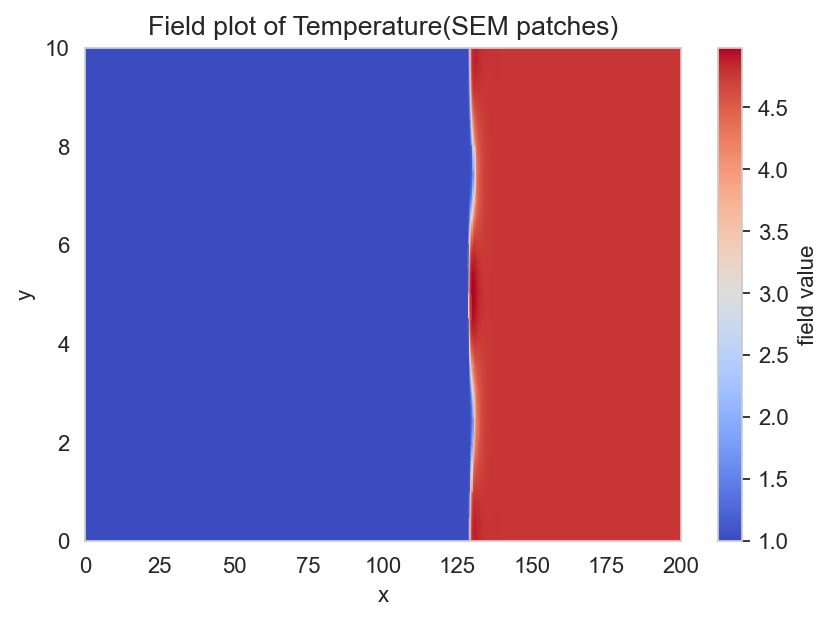

In [20]:
Plot2D.plot_field(ds.msh, ds.T,plot_name="Temperature", mode="sem", cmap="coolwarm")

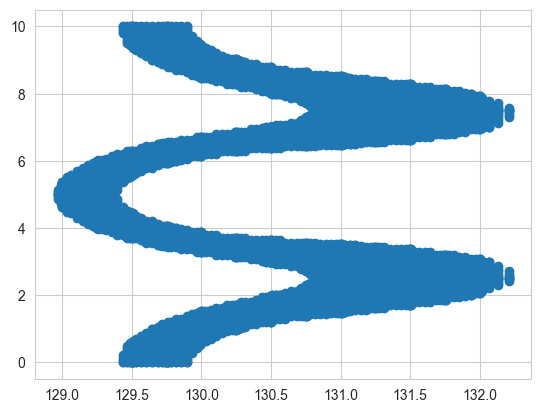

In [21]:

plt.figure()
plt.scatter(front.df.x, front.df.y)
plt.show()

## Pearson Corellation

In [22]:
Plot2D.print_pearson(front.df, cols=["u","v","T","H2","O2", "Le_def"])

            u    v      T     H2     O2  Le_def
u       1.000  0.0  0.723 -0.964 -0.583  -0.987
v       0.000  1.0  0.000 -0.000 -0.000  -0.000
T       0.723  0.0  1.000 -0.859 -0.976  -0.655
H2     -0.964 -0.0 -0.859  1.000  0.758   0.943
O2     -0.583 -0.0 -0.976  0.758  1.000   0.503
Le_def -0.987 -0.0 -0.655  0.943  0.503   1.000


## Pairplot

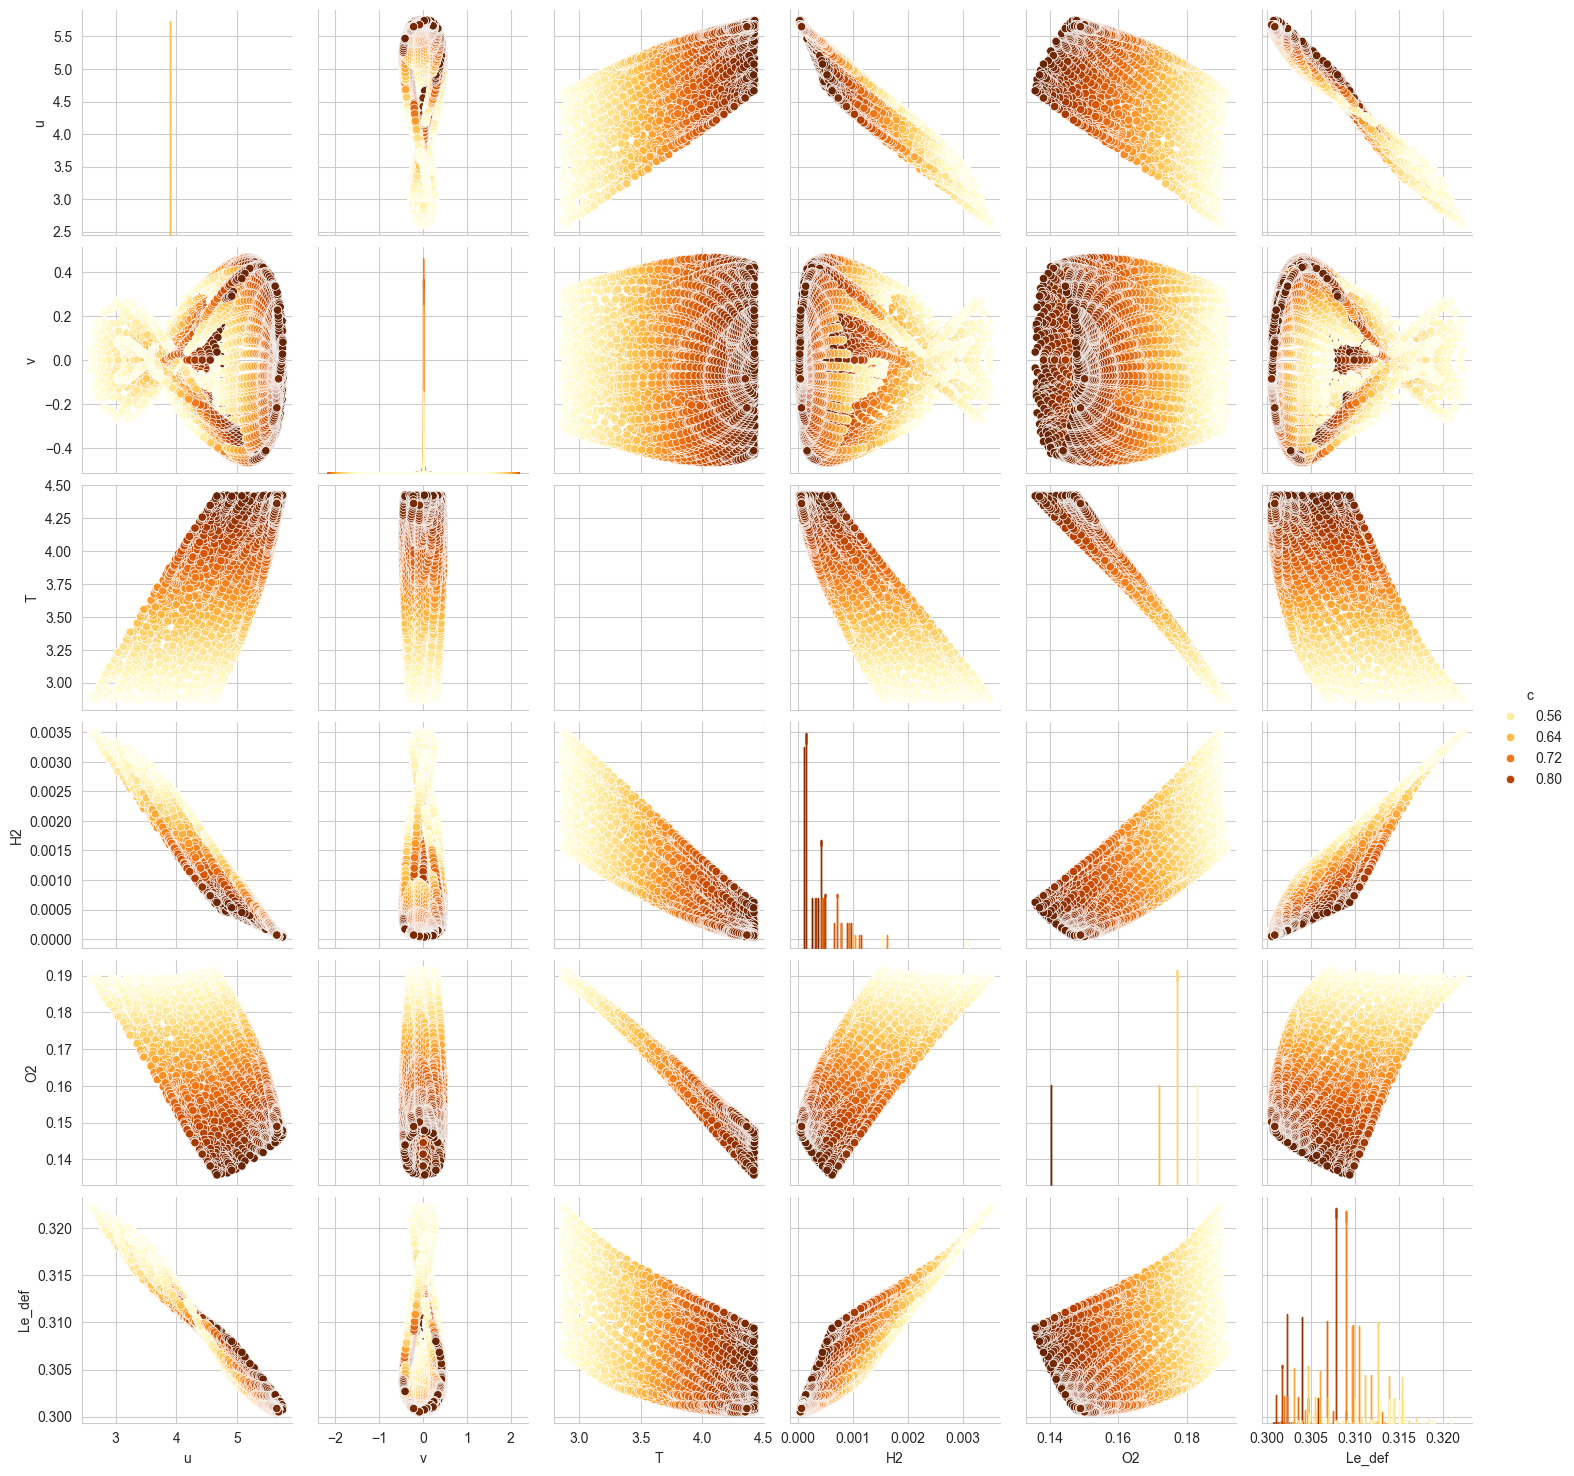

In [23]:
#Plot2D.heat_map(front.df, cols =
#       ["u","v","T","H2","O2", "Le_def"])

cols = ["u","v","T","H2","O2","Le_def"]
sns.pairplot(
    front.df,
    vars=cols,
    hue="c",
    palette="YlOrBr",
    #diag_kind="hist"
    #diag_kws=dict(bins=40, edgecolor=None, alpha=0.8),
);



## NN for velocity prediction

Epoch 1/130
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1065 - val_loss: 0.0432
Epoch 2/130
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0374 - val_loss: 0.0303
Epoch 3/130
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0256 - val_loss: 0.0309
Epoch 4/130
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0280 - val_loss: 0.0233
Epoch 5/130
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0236 - val_loss: 0.0195
Epoch 6/130
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0213 - val_loss: 0.0230
Epoch 7/130
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216 - val_loss: 0.0217
Epoch 8/130
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0239 - val_loss: 0.0225
Epoch 9/130
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0219 - val_loss: 0.0157
Epoch 10/130
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0194 - val_loss: 0.0225
Epoch 11/130
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - val_loss: 0.0121
Epoch 12/130
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

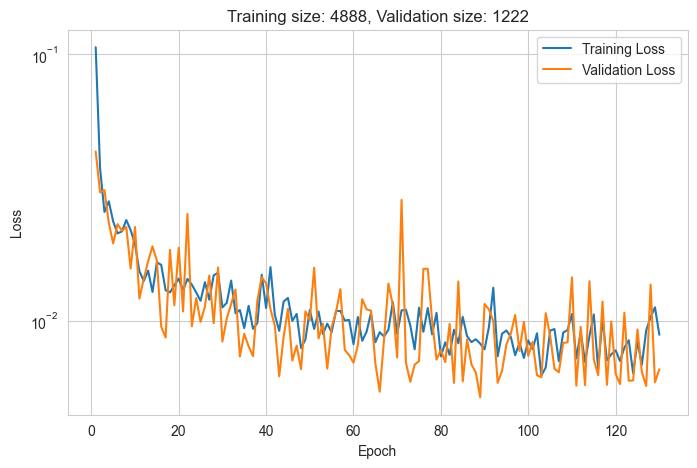

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


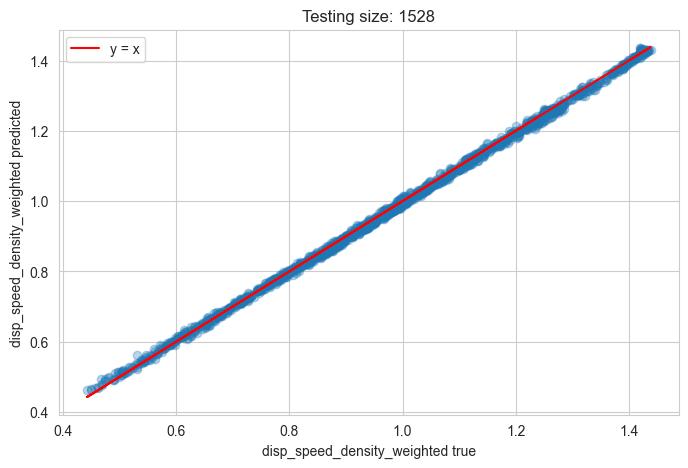

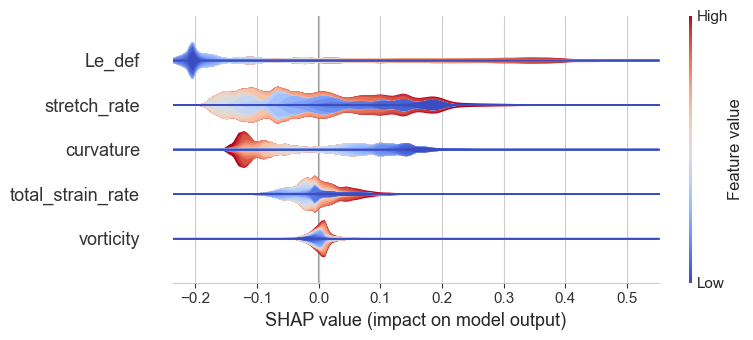

In [24]:

feature_names = [ 'curvature' ,'stretch_rate','total_strain_rate', 'Le_def', 'vorticity']


ml = MachineLearningModel(features=feature_names, target="disp_speed_density_weighted", test_size=0.2, n_epoch= 130)
ml.prepare_data(front.df).build_model().train()
ml.plot_loss()
ml.evaluate()
ml.shap_summary()

